#Implementing a convolutional autoencoder with Keras and TensorFlow

# Imports 


---


[more about activation functions](https://medium.com/@shrutijadon10104776/survey-on-activation-functions-for-deep-learning-9689331ba092)
![activation functions](https://miro.medium.com/max/1200/1*ZafDv3VUm60Eh10OeJu1vw.png)

In [1]:
# import the necessary packages
%tensorflow_version 2.x
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Reshape
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.datasets import fashion_mnist

TensorFlow 2.x selected.


In [0]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
import matplotlib

[Batch normalization - read this article](https://mlexplained.com/2018/01/10/an-intuitive-explanation-of-why-batch-normalization-really-works-normalization-in-deep-learning-part-1/)

In [0]:
class ConvAutoencoder:
	
	@staticmethod
	def build(width, height, depth, filters=(32, 64), latentDim=16):
		# initialize the input shape to be "channels last" along with
		# the channels dimension itself
		# channels dimension itself
		inputShape = (height, width, depth)
		chanDim = -1

		# define the input to the encoder
		inputs = Input(shape=inputShape)
		x = inputs

		# loop over the number of filters
		for f in filters:
			# apply a CONV => RELU => BN operation
			x = Conv2D(f, (3, 3), strides=2, padding="same")(x)
			x = LeakyReLU(alpha=0.2)(x)
			x = BatchNormalization(axis=chanDim)(x)
		print('encoder',x)
		# flatten the network and then construct our latent vector
		volumeSize = K.int_shape(x)
		x = Flatten()(x)
		latent = Dense(latentDim)(x)

		# build the encoder model
		encoder = Model(inputs, latent, name="encoder")

		# start building the decoder model which will accept the
		# output of the encoder as its inputs
		latentInputs = Input(shape=(latentDim,))
		x = Dense(np.prod(volumeSize[1:]))(latentInputs)
		x = Reshape((volumeSize[1], volumeSize[2], volumeSize[3]))(x)

		# loop over our number of filters again, but this time in
		# reverse order
		for f in filters[::-1]:
			# apply a CONV_TRANSPOSE => RELU => BN operation
			x = Conv2DTranspose(f, (3, 3), strides=2,
				padding="same")(x)
			x = LeakyReLU(alpha=0.2)(x)
			x = BatchNormalization(axis=chanDim)(x)
		print('decoder',x)
		# apply a single CONV_TRANSPOSE layer used to recover the
		# original depth of the image
		x = Conv2DTranspose(depth, (3, 3), padding="same")(x)
		outputs = Activation("sigmoid")(x)

		# build the decoder model
		decoder = Model(latentInputs, outputs, name="decoder")

		# our autoencoder is the encoder + decoder
		autoencoder = Model(inputs, decoder(encoder(inputs)),name="autoencoder")

		# return a 3-tuple of the encoder, decoder, and autoencoder
		return (encoder, decoder, autoencoder)

# initialize the number of epochs to train for and batch size

In [0]:
EPOCHS = 2
BS = 32

# load the Fashion MNIST dataset


In [5]:
print("[INFO] loading Fashion MNIST dataset...")
((trainX, _), (testX, _)) = fashion_mnist.load_data()

[INFO] loading Fashion MNIST dataset...


# using the autoencoder

add a channel dimension to every image in the dataset, then scale
the pixel intensities to the range [0, 1]

In [0]:
trainX = np.expand_dims(trainX, axis=-1)
testX = np.expand_dims(testX, axis=-1)
trainX = trainX.astype("float32") / 255.0
testX = testX.astype("float32") / 255.0

# construct our convolutional autoencoder

In [22]:
print("[INFO] building autoencoder...")
(encoder, decoder, autoencoder) = ConvAutoencoder.build(28, 28, 1)
opt = Adam(lr=1e-3)
autoencoder.compile(loss="mse", optimizer=opt)

[INFO] building autoencoder...
encoder Tensor("batch_normalization_5/Identity:0", shape=(None, 7, 7, 64), dtype=float32)
decoder Tensor("batch_normalization_7/Identity:0", shape=(None, 28, 28, 32), dtype=float32)


# train the convolutional autoencoder

In [23]:
H = autoencoder.fit(
	trainX, trainX,
	validation_data=(testX, testX),
	epochs=EPOCHS,
	batch_size=BS)

Epoch 1/20
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0182 - val_loss: 0.0140
Epoch 2/20
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0125 - val_loss: 0.0116
Epoch 3/20
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0116 - val_loss: 0.0113
Epoch 4/20
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0112 - val_loss: 0.0117
Epoch 5/20
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0108 - val_loss: 0.0107
Epoch 6/20
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0106 - val_loss: 0.0104
Epoch 7/20
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0104 - val_loss: 0.0102
Epoch 8/20
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0102 - val_loss: 0.0102
Epoch 9/20
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0101 - val_loss: 0.0101
Epoch 10/20
1875/1875 [==============================] - 7s 4ms/step - loss: 0.010

# construct a plot that plots and saves the training history

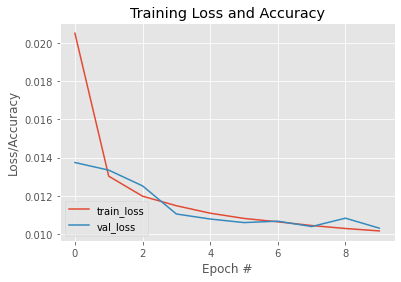

In [9]:
N = np.arange(0, EPOCHS)
plt.style.use("ggplot")
plt.figure()
plt.plot(N, H.history["loss"], label="train_loss")
plt.plot(N, H.history["val_loss"], label="val_loss")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig("plot.png")

# use the convolutional autoencoder 
 Make predictions on the testing images, then initialize our list of output images


In [24]:
print("[INFO] making predictions...")
decoded = autoencoder.predict(testX)
outputs = None
samples=8

[INFO] making predictions...


# loop over our number of output samples

In [25]:
for i in range(0, samples):
	# grab the original image and reconstructed image
	original = (testX[i] * 255).astype("uint8")
	recon = (decoded[i] * 255).astype("uint8")

	# stack the original and reconstructed image side-by-side
	output = np.hstack([original, recon])

	# if the outputs array is empty, initialize it as the current
	# side-by-side image display
	if outputs is None:
		outputs = output

	# otherwise, vertically stack the outputs
	else:
		outputs = np.vstack([outputs, output])

# save the outputs image to disk
cv2.imwrite("output.png", outputs)

True

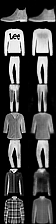

In [26]:
from PIL import Image
Image.open('/content/output.png')